<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC2_FD004_MLP_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%pip install scikeras;
%pip install -U tensorflow-addons;

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import shap

H:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from datetime import datetime

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.base import BaseEstimator,RegressorMixin

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

from keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow_addons as tfa
from tensorflow_addons.metrics import RSquare as R2



from scikeras.wrappers import KerasRegressor

In [7]:
sns.set_palette('colorblind')

In [8]:
# Reproducibility
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
tf.config.experimental.enable_op_determinism()

# Data Preparation

In [10]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    IN_COLAB = True
    folder="/content/CMaps/"

    # Dataset Download 
    os.system('git clone https://github.com/arthursl12/dataset_2')
    os.system('mv /content/dataset_2/CMaps /content/CMaps')
    os.system('mv /content/dataset_2/data_processing /content/data_processing')
    os.system('rm -rf dataset_2')
else:
    print('Not running on CoLab')
    IN_COLAB = False
    folder="CMaps/"
    %cd dataset_2/

Not running on CoLab
C:\Users\Arthur Lima\POC\dataset_2


In [11]:
from data_processing.processing import DatasetProcessing
from data_processing.training import HyperparameterSearch, reclipper_scorer
from data_processing.eval import Evaluation

In [12]:
proc = DatasetProcessing()

## Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [13]:
index_cols, settings_cols, sensors_cols, cols = proc.column_names()
train, test, y_test = proc.read_dataset(4,folder=folder)
train

unit_number  time     op_1    op_2   op_3     s_0     s_1      s_2  \
0                1     1  42.0049  0.8400  100.0  445.00  549.68  1343.43   
1                1     2  20.0020  0.7002  100.0  491.19  606.07  1477.61   
2                1     3  42.0038  0.8409  100.0  445.00  548.95  1343.12   
3                1     4  42.0000  0.8400  100.0  445.00  548.70  1341.24   
4                1     5  25.0063  0.6207   60.0  462.54  536.10  1255.23   
...            ...   ...      ...     ...    ...     ...     ...      ...   
61244          249   251   9.9998  0.2500  100.0  489.05  605.33  1516.36   
61245          249   252   0.0028  0.0015  100.0  518.67  643.42  1598.92   
61246          249   253   0.0029  0.0000  100.0  518.67  643.68  1607.72   
61247          249   254  35.0046  0.8400  100.0  449.44  555.77  1381.29   
61248          249   255  42.0030  0.8400  100.0  445.00  549.85  1369.75   

           s_3    s_4  ...    s_11     s_12     s_13     s_14  s_15  s_16  \
0      1112.93   3.91  ...  129.78  2387.99  8074.83   9.3335  0.02   330   
1      1237.50   9.35  ...  312.59  2387.73  8046.13   9.1913  0.02   361   
2      1117.05   3.91  ...  129.62  2387.97  8066.62   9.4007  0.02   329   
3      1118.03   3.91  ...  129.80  2388.02  8076.05   9.3369  0.02   328   
4      1033.59   7.05  ...  164.11  2028.08  7865.80  10.8366  0.02   305   
...        ...    ...  ...     ...      ...      ...      ...   ...   ...   
61244  1315.28  10.52  ...  380.16  2388.73  8185.69   8.4541  0.03   372   
61245  1426.77  14.62  ...  535.02  2388.46  8185.47   8.2221  0.03   396   
61246  1430.56  14.62  ...  535.41  2388.48  8193.94   8.2525  0.03   395   
61247  1148.18   5.48  ...  187.92  2388.83  8125.64   9.0515  0.02   337   
61248  1147.45   3.91  ...  134.32  2388.66  8144.33   9.1207  0.02   333   

       s_17    s_18   s_19     s_20  
0      2212  100.00  10.62   6.3670  
1      2324  100.00  24.37  14.6552  
2      2212  100.00  10.48   6.4213  
3      2212  100.00  10.54   6.4176  
4      1915   84.93  14.03   8.6754  
...     ...     ...    ...      ...  
61244  2319  100.00  29.11  17.5234  
61245  2388  100.00  39.38  23.7151  
61246  2388  100.00  39.78  23.8270  
61247  2223  100.00  15.26   9.0774  
61248  2212  100.00  10.66   6.4341  

[61249 rows x 26 columns]

## Preprocessing

### Test Set Transformation 
Test set has samples for all cycles, but has annotations only for last one

In [14]:
test.shape, y_test.shape

((41214, 26), (248, 1))

In [15]:
test_last = proc.transform_test_keep_setting(test)
test_last.head()

op_1    op_2   op_3     s_0     s_1      s_2      s_3   s_4   s_5  \
0  25.0070  0.6214   60.0  462.54  537.66  1264.31  1046.41  7.05  8.99   
1  41.9989  0.8400  100.0  445.00  549.96  1354.05  1133.55  3.91  5.72   
2  42.0005  0.8401  100.0  445.00  549.47  1341.06  1118.90  3.91  5.69   
3  25.0018  0.6207   60.0  462.54  536.06  1253.49  1038.53  7.05  9.00   
4  25.0039  0.6200   60.0  462.54  537.36  1263.60  1052.52  7.05  9.03   

      s_6  ...    s_11     s_12     s_13     s_14  s_15  s_16  s_17    s_18  \
0  176.56  ...  166.19  2028.53  7890.31  10.7615  0.02   308  1915   84.93   
1  139.03  ...  130.17  2387.72  8073.44   9.3925  0.02   331  2212  100.00   
2  139.26  ...  130.73  2388.18  8095.58   9.2974  0.02   330  2212  100.00   
3  175.63  ...  164.91  2028.30  7878.63  10.8396  0.02   306  1915   84.93   
4  175.53  ...  164.95  2028.24  7873.75  10.9094  0.02   307  1915   84.93   

    s_19    s_20  
0  14.41  8.6329  
1  10.58  6.4325  
2  10.61  6.3488  
3  14.41  8.5696  
4  14.19  8.6248  

[5 rows x 24 columns]

In [16]:
X_test = test_last

### Remaining Useful Life (RUL)

In [17]:
train = proc.add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

unit_number  time  RUL
0            1     1  320
1            1     2  319
2            1     3  318
3            1     4  317
4            1     5  316

## Attributes and target separation

In [18]:
X_train, y_train = proc.X_y_train_divide_with_settings(train)

In [19]:
y_train.head()

RUL
0  320
1  319
2  318
3  317
4  316

In [20]:
X_train.head()

op_1    op_2   op_3     s_0     s_1      s_2      s_3   s_4    s_5  \
0  42.0049  0.8400  100.0  445.00  549.68  1343.43  1112.93  3.91   5.70   
1  20.0020  0.7002  100.0  491.19  606.07  1477.61  1237.50  9.35  13.61   
2  42.0038  0.8409  100.0  445.00  548.95  1343.12  1117.05  3.91   5.69   
3  42.0000  0.8400  100.0  445.00  548.70  1341.24  1118.03  3.91   5.70   
4  25.0063  0.6207   60.0  462.54  536.10  1255.23  1033.59  7.05   9.00   

      s_6  ...    s_11     s_12     s_13     s_14  s_15  s_16  s_17    s_18  \
0  137.36  ...  129.78  2387.99  8074.83   9.3335  0.02   330  2212  100.00   
1  332.10  ...  312.59  2387.73  8046.13   9.1913  0.02   361  2324  100.00   
2  138.18  ...  129.62  2387.97  8066.62   9.4007  0.02   329  2212  100.00   
3  137.98  ...  129.80  2388.02  8076.05   9.3369  0.02   328  2212  100.00   
4  174.82  ...  164.11  2028.08  7865.80  10.8366  0.02   305  1915   84.93   

    s_19     s_20  
0  10.62   6.3670  
1  24.37  14.6552  
2  10.48   6.4213  
3  10.54   6.4176  
4  14.03   8.6754  

[5 rows x 24 columns]

## Training and Evaluation functions

In [21]:
eval = Evaluation()

In [22]:
search = HyperparameterSearch()

# Sensor Dictionary

In [23]:
sensor_dictionary = {
    "s_0": "T2 (s_0)",
    "s_1": "T24 (s_1)",
    "s_2": "T30 (s_2)",
    "s_3": "T50 (s_3)",
    "s_4": "P2 (s_4)",
    "s_5": "P15 (s_5)",
    "s_6": "P30 (s_6)",
    "s_7": "Nf (s_7)",
    "s_8": "Nc (s_8)",
    "s_9": "epr (s_9)",
    "s_10": "Ps30 (s_10)",
    "s_11": "phi (s_11)",
    "s_12": "NRf (s_12)",
    "s_13": "NRc (s_13)",
    "s_14": "BPR (s_14)",
    "s_15": "farB (s_15)",
    "s_16": "htBleed (s_16)",
    "s_17": "Nf_dmd (s_17)",
    "s_18": "PCNfR_dmd (s_18)",
    "s_19": "W31 (s_19)",
    "s_20": "W32 (s_20)"
}
sensor_dictionary.values()

dict_values(['T2 (s_0)', 'T24 (s_1)', 'T30 (s_2)', 'T50 (s_3)', 'P2 (s_4)', 'P15 (s_5)', 'P30 (s_6)', 'Nf (s_7)', 'Nc (s_8)', 'epr (s_9)', 'Ps30 (s_10)', 'phi (s_11)', 'NRf (s_12)', 'NRc (s_13)', 'BPR (s_14)', 'farB (s_15)', 'htBleed (s_16)', 'Nf_dmd (s_17)', 'PCNfR_dmd (s_18)', 'W31 (s_19)', 'W32 (s_20)'])

# MLP Construction

## Callbacks

In [24]:
# Early Stopping Callback
es = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                      patience=5, restore_best_weights=True)

In [25]:
# Printing Callback
def printLog(epoch, logs):
    print(
        f"E {epoch+1}\t: loss={logs['loss']:.3f}, "+
        f"rmse={logs['root_mean_squared_error']:.3f}, "+
        f"r2={logs['r_square']:.3f}; "+
        f"v_loss={logs['val_loss']:.3f}, "+
        f"v_rmse={logs['val_root_mean_squared_error']:.3f}, "+
        f"v_r2={logs['val_r_square']:.3f}; "
    )

printerCallback = LambdaCallback(on_epoch_end=printLog)

## Constants

In [26]:
# X_train must include indices
train3 = train.copy()
X_train_ = train3.drop(columns=[index_cols[1]]+["RUL"])

In [27]:
INPUT_SHAPE = 0

In [28]:
X_train_.columns = [index_cols[0]]+settings_cols+list(sensor_dictionary.values())
X_train_.columns

Index(['unit_number', 'op_1', 'op_2', 'op_3', 'T2 (s_0)', 'T24 (s_1)',
       'T30 (s_2)', 'T50 (s_3)', 'P2 (s_4)', 'P15 (s_5)', 'P30 (s_6)',
       'Nf (s_7)', 'Nc (s_8)', 'epr (s_9)', 'Ps30 (s_10)', 'phi (s_11)',
       'NRf (s_12)', 'NRc (s_13)', 'BPR (s_14)', 'farB (s_15)',
       'htBleed (s_16)', 'Nf_dmd (s_17)', 'PCNfR_dmd (s_18)', 'W31 (s_19)',
       'W32 (s_20)'],
      dtype='object')

In [29]:
sensors_cols = list(sensor_dictionary.values())

In [30]:
X_test.columns = settings_cols+list(sensor_dictionary.values())
X_test.columns

Index(['op_1', 'op_2', 'op_3', 'T2 (s_0)', 'T24 (s_1)', 'T30 (s_2)',
       'T50 (s_3)', 'P2 (s_4)', 'P15 (s_5)', 'P30 (s_6)', 'Nf (s_7)',
       'Nc (s_8)', 'epr (s_9)', 'Ps30 (s_10)', 'phi (s_11)', 'NRf (s_12)',
       'NRc (s_13)', 'BPR (s_14)', 'farB (s_15)', 'htBleed (s_16)',
       'Nf_dmd (s_17)', 'PCNfR_dmd (s_18)', 'W31 (s_19)', 'W32 (s_20)'],
      dtype='object')

## Wrapper

In [31]:
from sys import is_finalizing
from sklearn.metrics import r2_score

class MLPWrapperRegressor(BaseEstimator,RegressorMixin):
    def __init__(self, basemodel=None, clip_y=-1,
                 include_settings=False, poly_degree=1,
                 scaler=StandardScaler()):
        # Base parameters
        self.basemodel = basemodel
        self.clip_y = clip_y
        self.poly_degree = poly_degree
        self.include_settings = include_settings

        # Column indexers
        self.feature_cols = sensors_cols
        if(include_settings):
            self.feature_cols = settings_cols + self.feature_cols
        self.base_feature_cols = self.feature_cols

        # Scaler and PolyFeatures transformers
        self.scaler = scaler
        self.polyft = PolynomialFeatures(degree=self.poly_degree, 
                                         include_bias=False)

    def clean_cols(self,df):
        if("unit_number" in df.columns): del df["unit_number"]
        if("unit_number" in df.columns): del df["unit_number"]
        if("time" in df.columns): del df["time"]
        if((not self.include_settings)): 
            for col in settings_cols:
                if(col in df.columns): del df[col]
        return df

    def fit(self, X=None, y=None):
        # Drop irrelevant column
        data = pd.DataFrame(X).copy()
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.fit_transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.fit_transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        X_train = data.copy()
        
        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"]).copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_train = data2

        # Update input shape for future use
        global INPUT_SHAPE
        INPUT_SHAPE = X_train.shape[1]

        # Fit model
        self.basemodel.fit(X_train,y_train)
        return self
        
    def predict(self, X=None):
        # Perform transformation, if not done
        if (len(X.columns) != len(self.feature_cols)):
            X_train = self.transform_features(X)
        else:
            X_train = X
        return self.basemodel.predict(X_train)

    def transform_features(self, df):
        # Drop irrelevant column
        data = pd.DataFrame(df).copy()
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        # self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        return data

    def score(self, X, y, sample_weight=None):
        X_test = self.transform_features(X)

        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"]).copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_test = data2

        # Predict on test data
        y_pred = self.predict(X_test)
        return r2_score(y_test, y_pred, sample_weight=sample_weight)

## Test Data

In [32]:
def scale_test(test,model):
    test2 = pd.DataFrame(test)
    test2 = model.clean_cols(test2)

    # Apply polynomial features
    transf = model.polyft.transform(test2)
    test2 = pd.DataFrame(transf, 
                         columns=model.polyft.get_feature_names_out())

    # Scale the data (with train data parameters)
    test2 = model.scaler.transform(test2)
    test2 = pd.DataFrame(test2, 
                         columns=model.polyft.get_feature_names_out())
    return test2

## Constructor

In [33]:
def create_model(optim=Adam, learning_rate=1e-3, 
                 layer1=32  , activation1="tanh"    , dropout1=0.1,
                 layer2=None, activation2="tanh"    , dropout2=0.1,
                 layer3=None, activation3="tanh"    , dropout3=0.1,
                 layer4=None, activation4="tanh"    , dropout4=0.1,
                 print_summary=False, loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()]):
    model = Sequential()

    # Fully Connected Layer
    model.add(Dense(layer1, input_dim=INPUT_SHAPE, activation=activation1))
    model.add(Dropout(dropout1))

    # Additional hidden layers
    if(layer2 is not None):
        model.add(Dense(layer2, activation=activation2))
        model.add(Dropout(dropout2))
        if (layer3 is not None):
            model.add(Dense(layer3, activation=activation3))
            model.add(Dropout(dropout3))
            if (layer4 is not None):
                model.add(Dense(layer4, activation=activation4))
                model.add(Dropout(dropout4))

    # Output Layer
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optim(learning_rate=learning_rate), 
                  metrics=metrics)
    
    if(print_summary): model.summary()
    return model

# Model (ANN-3)

## Train

In [34]:
CLIP=80

model = MLPWrapperRegressor(
        clip_y=CLIP, scaler=StandardScaler(), poly_degree=1,
        include_settings=True,
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=277,
                           epochs=50,
                           model__activation1='tanh',
                           model__activation2='elu',
                           model__activation3='relu',
                           model__dropout1=0.15180815010798232, 
                           model__dropout2=0.4099007005621048, 
                           model__dropout3=0.1, 
                           model__layer1=197, 
                           model__layer2=353, 
                           model__layer3=261,  
                           model__learning_rate=0.0041467234962615715,
                           model__optim=Adam,
                           validation_split=0.17508243717937616, 
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )
model

MLPWrapperRegressor(basemodel=KerasRegressor(batch_size=277, callbacks=[<keras.callbacks.EarlyStopping object at 0x000001AC2E752C10>, <keras.callbacks.LambdaCallback object at 0x000001AC377D4E20>], epochs=50, model=<function create_model at 0x000001AC35E2D790>, model__activation1='tanh', model__activation2='elu', model__activation3='relu', model__dropout1=0.1518081...ing_rate=0.0041467234962615715, model__loss='mse', model__metrics=[<keras.metrics.RootMeanSquaredError object at 0x000001AC39B1AF10>, <tensorflow_addons.metrics.r_square.RSquare object at 0x000001AC39B4C160>], model__optim=<class 'keras.optimizer_v2.adam.Adam'>, print_summary=True, validation_split=0.17508243717937616, verbose=0),
                    clip_y=80, include_settings=True)

In [35]:
model.fit(X_train_, y_train)
print("Finished:", datetime.now())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 197)               4925      
                                                                 
 dropout (Dropout)           (None, 197)               0         
                                                                 
 dense_1 (Dense)             (None, 353)               69894     
                                                                 
 dropout_1 (Dropout)         (None, 353)               0         
                                                                 
 dense_2 (Dense)             (None, 261)               92394     
                                                                 
 dropout_2 (Dropout)         (None, 261)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2

In [36]:
# Scaling and formatting test data
test_sc = scale_test(X_test,model)

# Clipping test labels
reclipped_y = y_test.copy()
if(CLIP > 0): reclipped_y = reclipped_y["RUL"].clip(upper=CLIP, inplace=False)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_sc))
print("Finished:", datetime.now())

R2=0.850,RMSE=-10.478
Finished: 2022-11-08 10:04:19.556825


## Shap Values

In [37]:
X_train_

unit_number     op_1    op_2   op_3  T2 (s_0)  T24 (s_1)  T30 (s_2)  \
0                1  42.0049  0.8400  100.0    445.00     549.68    1343.43   
1                1  20.0020  0.7002  100.0    491.19     606.07    1477.61   
2                1  42.0038  0.8409  100.0    445.00     548.95    1343.12   
3                1  42.0000  0.8400  100.0    445.00     548.70    1341.24   
4                1  25.0063  0.6207   60.0    462.54     536.10    1255.23   
...            ...      ...     ...    ...       ...        ...        ...   
61244          249   9.9998  0.2500  100.0    489.05     605.33    1516.36   
61245          249   0.0028  0.0015  100.0    518.67     643.42    1598.92   
61246          249   0.0029  0.0000  100.0    518.67     643.68    1607.72   
61247          249  35.0046  0.8400  100.0    449.44     555.77    1381.29   
61248          249  42.0030  0.8400  100.0    445.00     549.85    1369.75   

       T50 (s_3)  P2 (s_4)  P15 (s_5)  ...  phi (s_11)  NRf (s_12)  \
0        1112.93      3.91       5.70  ...      129.78     2387.99   
1        1237.50      9.35      13.61  ...      312.59     2387.73   
2        1117.05      3.91       5.69  ...      129.62     2387.97   
3        1118.03      3.91       5.70  ...      129.80     2388.02   
4        1033.59      7.05       9.00  ...      164.11     2028.08   
...          ...       ...        ...  ...         ...         ...   
61244    1315.28     10.52      15.46  ...      380.16     2388.73   
61245    1426.77     14.62      21.57  ...      535.02     2388.46   
61246    1430.56     14.62      21.57  ...      535.41     2388.48   
61247    1148.18      5.48       7.96  ...      187.92     2388.83   
61248    1147.45      3.91       5.69  ...      134.32     2388.66   

       NRc (s_13)  BPR (s_14)  farB (s_15)  htBleed (s_16)  Nf_dmd (s_17)  \
0         8074.83      9.3335         0.02             330           2212   
1         8046.13      9.1913         0.02             361           2324   
2         8066.62      9.4007         0.02             329           2212   
3         8076.05      9.3369         0.02             328           2212   
4         7865.80     10.8366         0.02             305           1915   
...           ...         ...          ...             ...            ...   
61244     8185.69      8.4541         0.03             372           2319   
61245     8185.47      8.2221         0.03             396           2388   
61246     8193.94      8.2525         0.03             395           2388   
61247     8125.64      9.0515         0.02             337           2223   
61248     8144.33      9.1207         0.02             333           2212   

       PCNfR_dmd (s_18)  W31 (s_19)  W32 (s_20)  
0                100.00       10.62      6.3670  
1                100.00       24.37     14.6552  
2                100.00       10.48      6.4213  
3                100.00       10.54      6.4176  
4                 84.93       14.03      8.6754  
...                 ...         ...         ...  
61244            100.00       29.11     17.5234  
61245            100.00       39.38     23.7151  
61246            100.00       39.78     23.8270  
61247            100.00       15.26      9.0774  
61248            100.00       10.66      6.4341  

[61249 rows x 25 columns]

In [47]:
train_sc = scale_test(X_train_, model)
train_np = np.array(train_sc)
feature_names = train_sc.columns
explainer = shap.DeepExplainer(model.basemodel.model_, train_np)

# 1k: instant
# 6k: ~40s
# 21k (all): ~6min

shap_values = explainer.shap_values(train_np)
shap_values = shap_values[0]
explainer.expected_value = np.array(explainer.expected_value)
explainer.expected_value[0]

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


67.37633

In [48]:
shap_values.shape

(61249, 24)

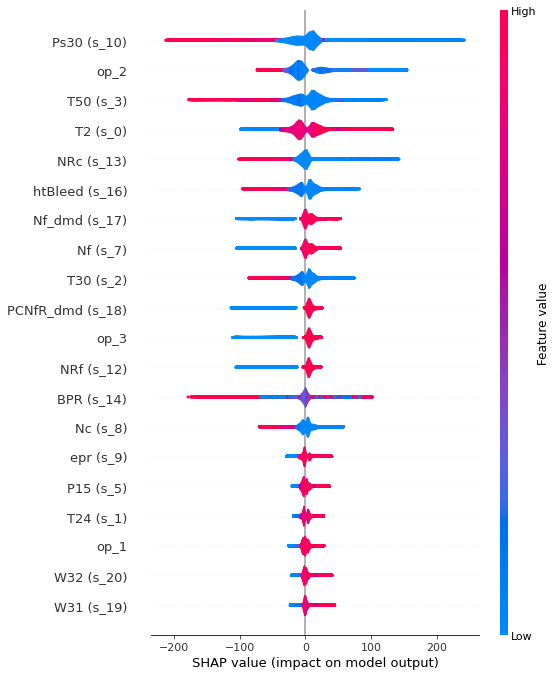

In [49]:
# shap.initjs()
shap.summary_plot(shap_values, train_np, plot_type="violin", 
                  feature_names=feature_names, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

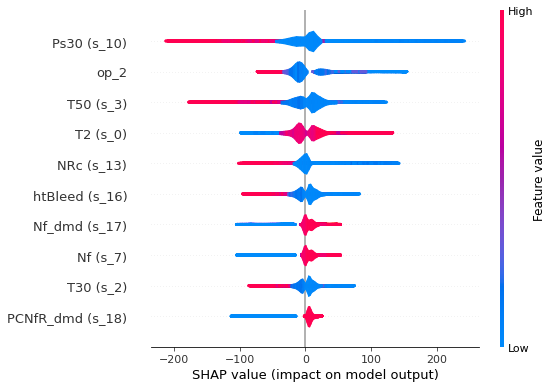

In [50]:
# shap.initjs()
shap.summary_plot(shap_values, train_np, plot_type="violin",max_display=10,
                  feature_names=feature_names, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

In [54]:
from scipy.ndimage import uniform_filter

def get_start_end(i, train=train):
    grouped = train.groupby("unit_number").count()["time"]
    start = np.sum(grouped[:i-1])
    end = start + grouped[i]
    return start,end

def shap_plot_unit(i, shap_values=shap_values, explainer=explainer, feature_names=feature_names, train=train, sma_window=0):
    shap.initjs()
    start,end = get_start_end(i,train)
    return shap.force_plot(explainer.expected_value, 
                    uniform_filter(shap_values[start:end], size=(sma_window,1), mode='nearest'), 
                    feature_names=feature_names)

In [55]:
shap_plot_unit(1)

In [56]:
shap_plot_unit(1,sma_window=5)

In [57]:
shap_plot_unit(32)

In [58]:
shap_plot_unit(32,sma_window=5)

In [59]:
shap_plot_unit(32,sma_window=10)

In [60]:
shap_plot_unit(32,sma_window=20)

In [61]:
shap_plot_unit(42)

In [62]:
shap_plot_unit(42,sma_window=10)

In [63]:
shap_plot_unit(42,sma_window=20)

In [65]:
get_start_end(42)

(10138, 10418)

In [66]:
filteded_42 = uniform_filter(shap_values[10138:10418], size=(20,1), mode='nearest')

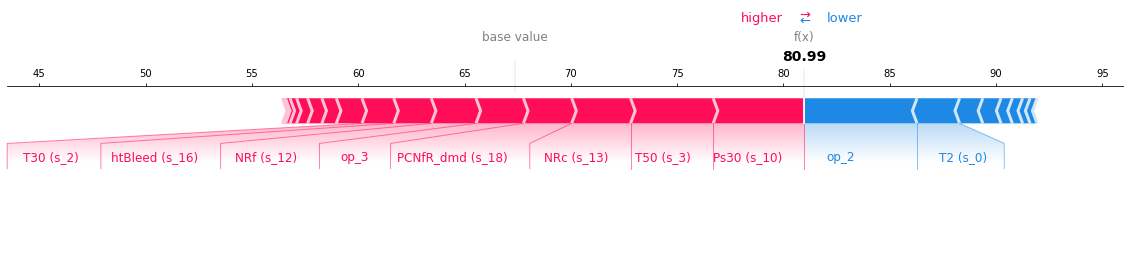

In [67]:
shap.force_plot(explainer.expected_value, filteded_42[0], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

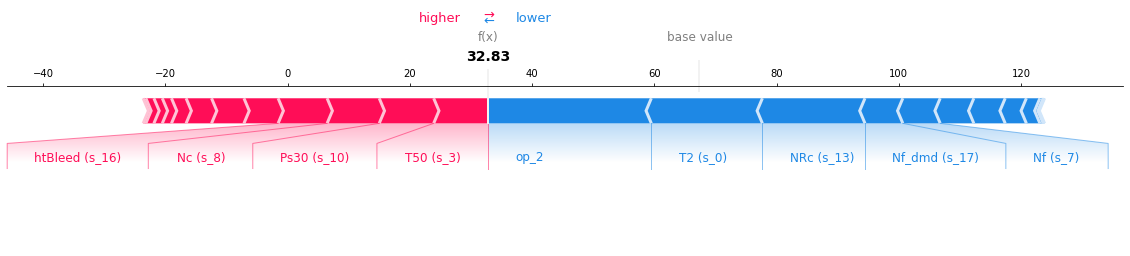

In [68]:
shap.force_plot(explainer.expected_value, filteded_42[250], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

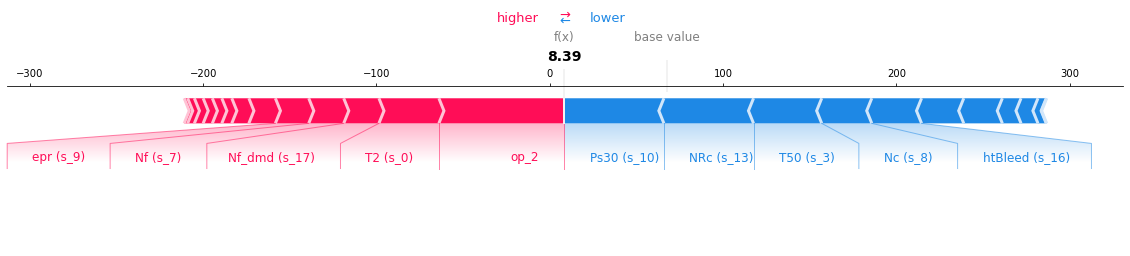

In [69]:
shap.force_plot(explainer.expected_value, filteded_42[-1], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

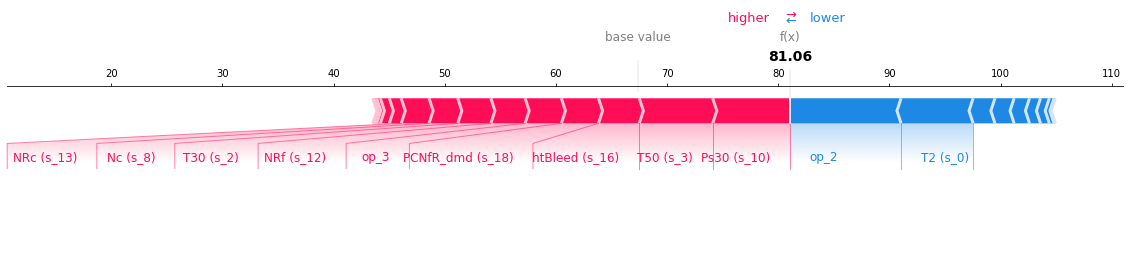

In [73]:
shap.force_plot(explainer.expected_value, shap_values[10138], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

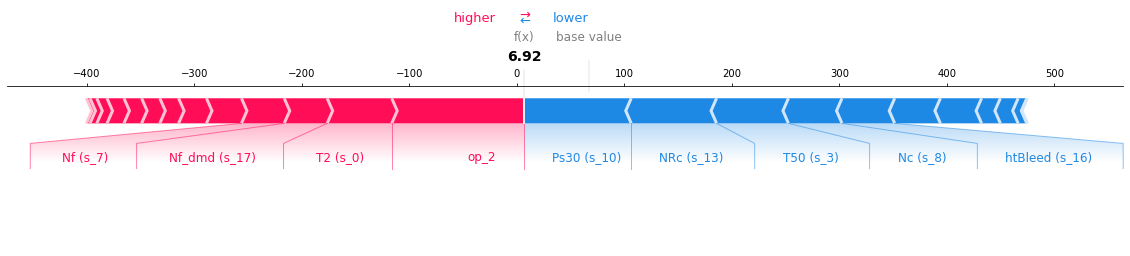

In [72]:
shap.force_plot(explainer.expected_value, shap_values[10417], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

In [74]:
get_start_end(15)

(3946, 4170)

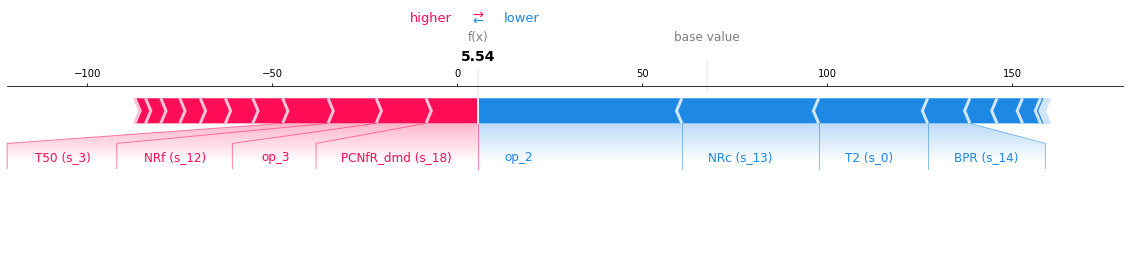

In [75]:
shap.force_plot(explainer.expected_value, shap_values[4169], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

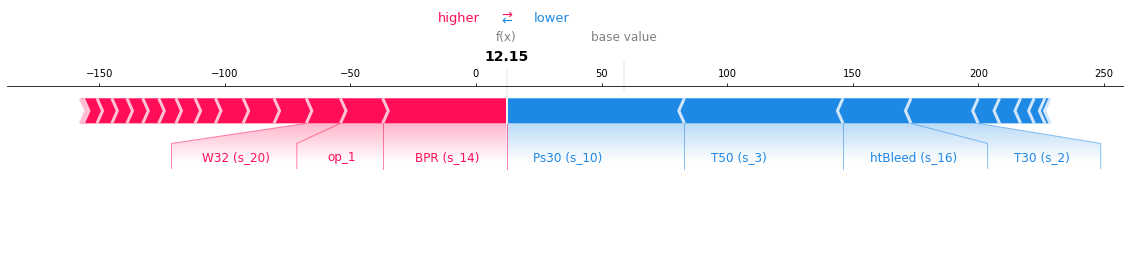

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[8471], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

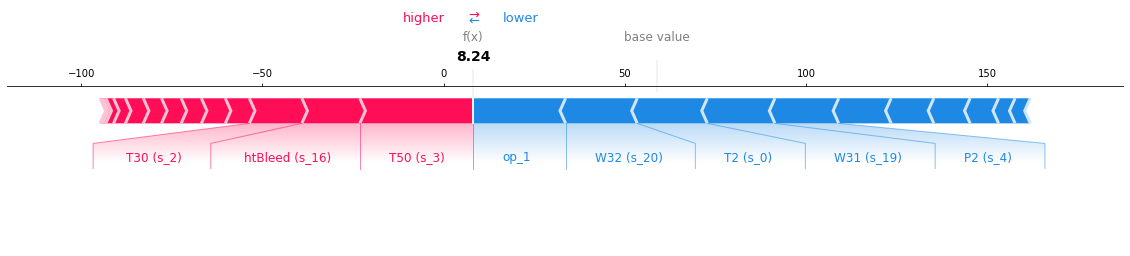

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[8472], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

## KernelExplainer

In [79]:
import warnings

In [80]:
train_sc = scale_test(X_train_, model)
train_np = np.array(train_sc[:100])
feature_names = train_sc.columns
explainer = shap.KernelExplainer(model.basemodel.model_, train_np)

# 1k: instant
# 6k: ~40s
# 21k (all): ~6min

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(train_np)
shap_values = shap_values[0]
explainer.expected_value = np.array(explainer.expected_value)
explainer.expected_value[0]

  0%|          | 0/100 [00:00<?, ?it/s]

81.15028755187988

In [87]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:50], 
                feature_names=feature_names)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
# plt.show()